In [1]:
import numpy as np
import urllib
import pandas as pd
import matplotlib as plt
import statsmodels.api as sm
%pylab inline

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#downloading the cuboframe    
urllib.urlretrieve("https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy","MTA_Fare.npy")

('MTA_Fare.npy', <httplib.HTTPMessage instance at 0x000000000BCA6DC8>)

In [3]:
mtaRide=np.load("MTA_Fare.npy")
mtaRide.shape

(600L, 23L, 194L)

There are
600 Manhattan Stations (wikipedia mentions 472 stations)
23 card types
194 Weeks

## Task 1: 
### Event detection: Identify the most prominent event. 
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [4]:
#first we check the shape of the data after doing "collapsing operations"
#one can sum time series for all stations
print (mtaRide.shape)
mta_allsum = np.nansum(mtaRide, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtaRide, axis=1)
print (mta_allsum.shape)


(600L, 23L, 194L)
(23L, 194L)
(600L, 194L)


We are trying to identify prominent events, independently of the type of pass and the the stations.
For this we need to group the data.

In [5]:
#We have integers, we convert them to floats
mtaRide=mtaRide.astype(float)

In [6]:
#we replace missing values (-1) with NaNs, so they don't affect future calculations
mtaRide[mtaRide<0]=np.nan

In [7]:
#We collapse the data across the different stations, averaging them 
mta_allavg = np.nanmean(mtaRide, axis=0)
print (mta_allavg.shape)

(23L, 194L)


C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


We now have the 194 weeks for each of the 23 type of passes

In [8]:
#Now we average the data across the 23 passes
mta_all_day=np.nanmean(mta_allavg,axis=0)
mta_all_day.shape

(194L,)

We now have 194 averages acrross stations and type of passes
We can assign the dates as follow:

In [9]:
#we create a data frame of dates using the information provided. The last date in the data is "02/21/2014",
#the first one is 05/21/2010
#the period is weekly, and the total periods are 194
#date_range creates the weeks in a way that makes it more convenient to end a week before the data (bah, it is what gave
#the most convenient result afterward)
date_rango=pd.date_range(end="02/14/2014",freq="W",periods=194)

In [10]:
#We create a dataframe using the average across the two axis and then adding the dates.
#we are assuming the dates are in order
mta_all_day=pd.DataFrame(mta_all_day)
mta_all_day["date"]=date_rango
mta_all_day.columns=["swipes_avg","date"]

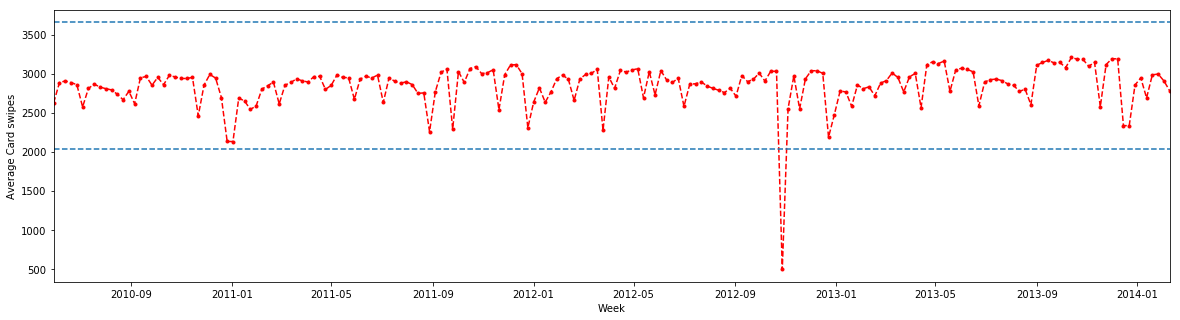

In [11]:
#Now we plot
plt.figure(figsize=(20,5))
plot(mta_all_day.date,mta_all_day.swipes_avg,"r.--")
axhline(y=np.nanmean(mta_all_day.swipes_avg)+3*np.nanstd(mta_all_day.swipes_avg),linestyle='--')
axhline(y=np.nanmean(mta_all_day.swipes_avg)-3*np.nanstd(mta_all_day.swipes_avg),linestyle="--")
xlabel("Week")
xlim(min(mta_all_day.date),max(mta_all_day.date))
ylabel("Average Card swipes");

Figure 1. Time series of average card swipes across stations and type of passes, from 05/21/2010 to 02/21/2014.
The tresholds used to determine extreme events are represented and were calculated as three standard deviations from the mean.
One particular weeks stands out.

After observing the graph we can see that there are no data points above the upper treshold, so we are going to see the event below the treshold.

In [12]:
#we index all events that are below the treshold
mta_all_day[mta_all_day.swipes_avg<np.nanmean(mta_all_day.swipes_avg)-3*np.nanstd(mta_all_day.swipes_avg)]

,swipes_avg,date
126,493.259546,2012-10-28


October 29, 2012, hurricane Sandy hit NYC. 
What is represented, after setting the treshold, is the week when Hurrican Sandy hit NYC.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [13]:
#We create a new data frame, where the rows are the date, and columns are the different riders
df2=pd.DataFrame(mta_allavg.T)

In [14]:
#what is the ratio of usage in the first 10 and last 10 weeks for all of the groups?
sum_ratio=np.nansum(df2[-10:])/np.nansum(df2[:10])

print "The sum ratio is",sum_ratio

The sum ratio is 1.04403997223


This gives an idea of the baseline ratio of change.

In [15]:
#here we have the labels
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  


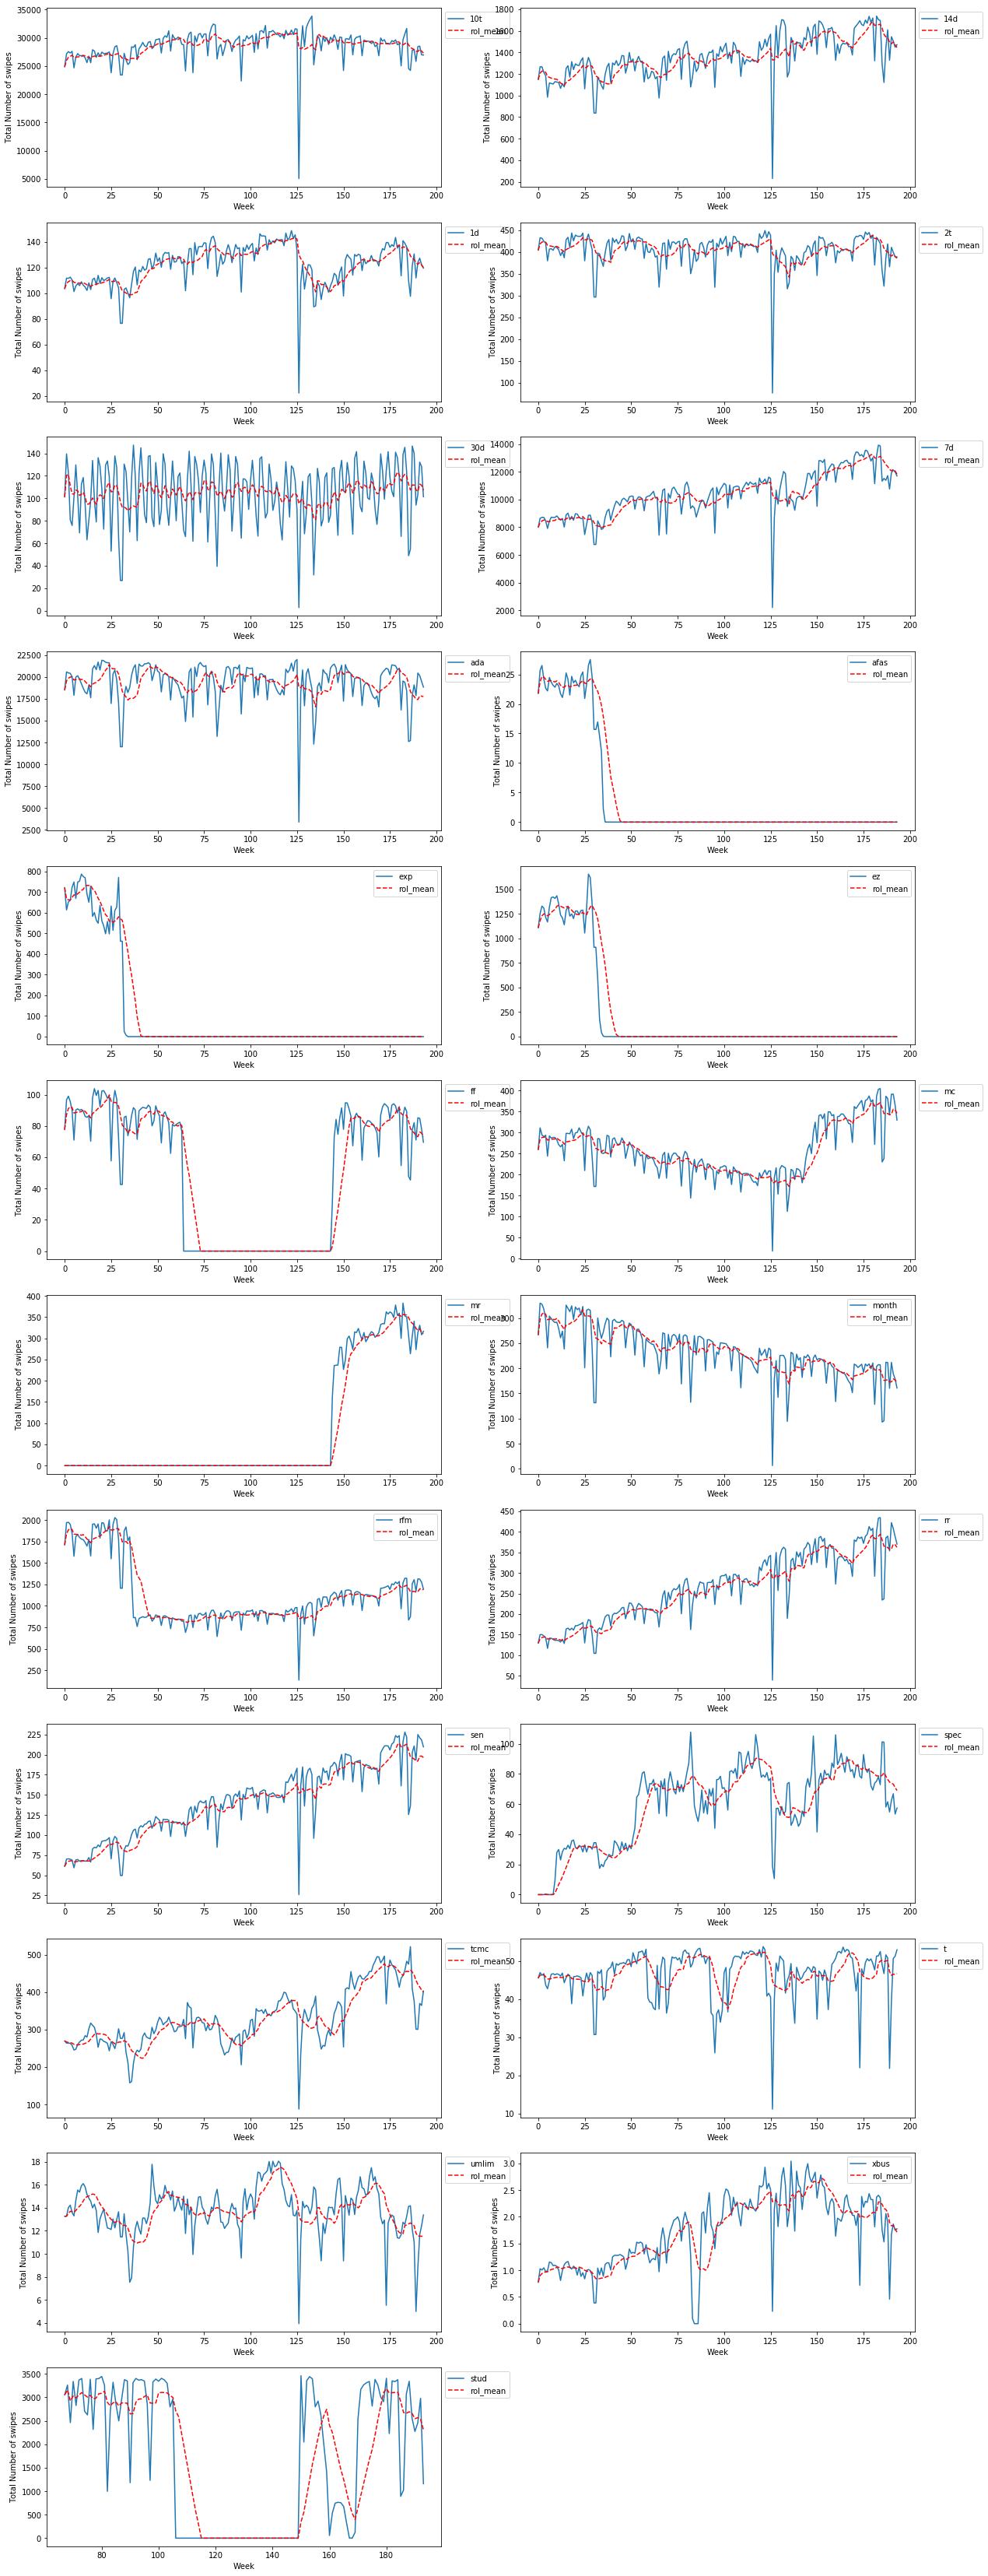

In [16]:
#we will plot everything with the rolling mean to check trends using our powerful prefrontal cortex
fig = plt.figure(figsize=(20,60))

for i in range(0,23):
    ax = fig.add_subplot(12,2,i+1)
    #plt.figure(figsize=(10,3))
    ax.plot(df2[i],label=ridetype[i])
    ax.plot(pd.rolling_mean(df2[i],10,min_periods=1),"r--",label="rol_mean")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Week")
    plt.ylabel("Total Number of swipes");

Figures 2. Note that some of the graphs don't have complete data for the period. We will not use those card types. 
The card types that we don't like are card types with index 7,8,9,10,12,22. 
There are some other card types that don't exist since the beginning but they are OK

In [17]:
#a list of the cards we don't like
boo_cards=[7,8,9,10,12,22]

In [18]:
#We will calculate all the ratios ignoring the boo cards we don't like
np_ratio=np.zeros(22)
for i in range(0,22):
    if i not in boo_cards:
        ratio=np.nansum(df2[-10:][i])/np.nansum(df2[:10][i])
        np_ratio[i]=ratio
        print "Card type",ridetype[i],"has a ratio of",np_ratio[i]
    

Card type 10t has a ratio of 1.02319178439
Card type 14d has a ratio of 1.25372312447
Card type 1d has a ratio of 1.11283317661
Card type 2t has a ratio of 0.935035542614
Card type 30d has a ratio of 1.0350076075
Card type 7d has a ratio of 1.3916067341
Card type ada has a ratio of 0.901033899272
Card type mc has a ratio of 1.21518958463
Card type month has a ratio of 0.579508303222
Card type rfm has a ratio of 0.650466150582
Card type rr has a ratio of 2.59651761186
Card type sen has a ratio of 2.91334837945
Card type spec has a ratio of 70.3085649318
Card type tcmc has a ratio of 1.53423894381
Card type t has a ratio of 1.02287151588
Card type umlim has a ratio of 0.810114959452
Card type xbus has a ratio of 1.66468392809


In [19]:
#we erase the ones that have 0 ratio, the boo indexes
np_ratio=np_ratio[np_ratio>0]

In [20]:
#we create a new list without the boo cards
ridetype_short=ridetype
ridetype_short=np.delete(ridetype_short,boo_cards)

In [21]:
#we extract the maximum and minimum ratio
print "The minimum trend is for",ridetype_short[np.where(np_ratio==min(np_ratio))][0],np_ratio[np_ratio==min(np_ratio)][0]
print "The maximum trend is for",ridetype_short[np.where(np_ratio==max(np_ratio))][0],np_ratio[np_ratio==max(np_ratio)][0]

The minimum trend is for month 0.579508303222
The maximum trend is for spec 70.3085649318


We will graph again the plots of this two card types

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


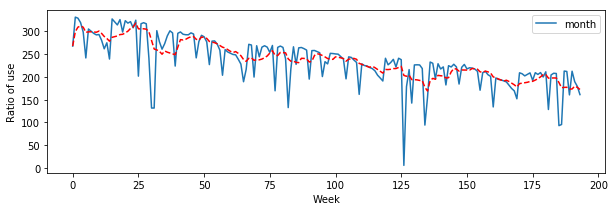

In [22]:
plt.figure(figsize=(10,3))
plt.plot(df2[13],label=ridetype[13])
plt.plot(pd.rolling_mean(df2[13],10,min_periods=1),"r--",label="")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Week")
plt.ylabel("Total Number of swipes")
ylabel("Ratio of use");

Figure 3. Monthly card type. Note the downward trend. 

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


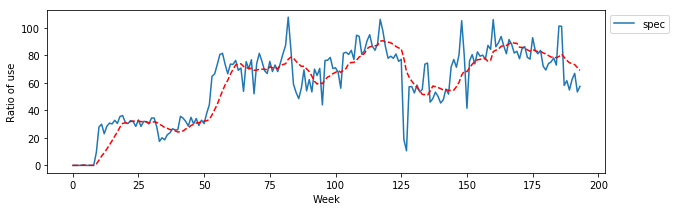

In [23]:
plt.figure(figsize=(10,3))
plt.plot(df2[17],label=ridetype[17])
plt.plot(pd.rolling_mean(df2[17],10,min_periods=1),"r--",label="")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Week")
plt.ylabel("Total Number of swipes")
ylabel("Ratio of use");

Figure 4. Special card type. Note the upward trend. Note that the card starts at 0, but the upward trend is evident nevertheless

Now we are goind to do AD Fuller test with 5% significance to check it formally.

H0: Unit root present, thus, non-stationary
HA: No unit root present, thus, stationary.
    
No unit root generally means stationarity.

In [24]:
print sm.tsa.adfuller(df2[0])

(-3.0324816134054133, 0.031970366002654627, 7L, 186L, {'5%': -2.8772078537639385, '1%': -3.466005071659723, '10%': -2.5751221620996647}, 3315.3512490981016)


In [25]:
print sm.tsa.adfuller(df2[13])[0],"and the critical value alpha=5% is",sm.tsa.adfuller(df2[13])[4]["5%"]
print sm.tsa.adfuller(df2[17])[0],"and the critical value alpha=5% is",sm.tsa.adfuller(df2[17])[4]["5%"]

-1.47928367843 and the critical value alpha=5% is -2.87720785376
-2.71670992 and the critical value alpha=5% is -2.87687522817


So we don't reject the Null Hypothesys that is has Unit root.  
If a Unit root is present, then neither of the card types are stationary.  
Compare this to a card without unit root:

In [26]:
print sm.tsa.adfuller(df2[0])[0],"and the critical value alpha=5% is",sm.tsa.adfuller(df2[0])[4]["5%"]

-3.03248161341 and the critical value alpha=5% is -2.87720785376


The statistic value is lower than the critical value, so we do reject the Null, and then no unit root present and thus, stationary

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
  """


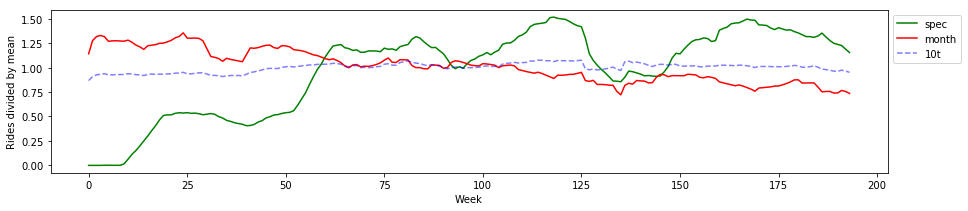

In [27]:
#one final plot dividing by the mean to show they are not stationary
plt.figure(figsize=(15,3))
plt.plot(pd.rolling_mean(df2[17],10,min_periods=1)/mean(df2[17]),"g",label=ridetype[17])
plt.plot(pd.rolling_mean(df2[13],10,min_periods=1)/mean(df2[13]),"r",label=ridetype[13])
plt.plot(pd.rolling_mean(df2[0],10,min_periods=1)/mean(df2[0]),"b--",alpha=0.5,label=ridetype[0])
plt.xlabel("Week")
plt.ylabel("Rides divided by mean")
plt.legend(bbox_to_anchor=(1, 1))

Figure 5. Both upward (special) and downward (monthly) rides for three card type across the 194 weeks (average card swipes divided by mean of the card type). The blue line is the 10 day pass, that is stationary according to AD Fuller test.

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


In [28]:
#I will call it "df3" even if is not a data frame
df3=np.nansum(mtaRide, axis=1) 

In [29]:
#checking shape
df3.shape 

(600L, 194L)

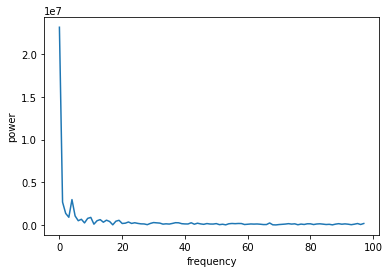

In [30]:
#let's plot only one station to see how it look like
plot(np.abs(np.fft.rfft(df3[0])))
xlabel("frequency")
ylabel("power")

Figure 6. Station 0. Graph just to check everything is as expected. There are some minor spikes that are less visible due to the high spike at the start. For further graphs it will be conveninient to graph ignoring the first point. 

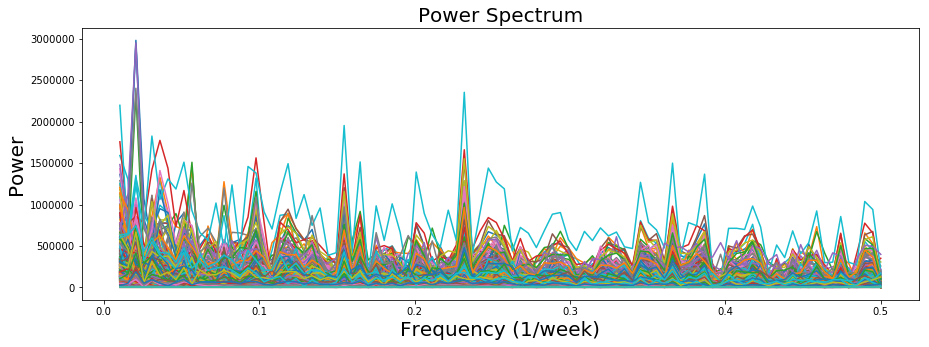

In [31]:
#Plotting everything in one chaotic graph
fig=plt.figure(figsize=(15,5))
for i in range (0,600):
    f = np.abs(np.fft.rfft(df3[i]))
    plot(np.fft.rfftfreq(194, 1)[2:], (f)[2:], '-')


plt.xlabel("Frequency (1/week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("Power Spectrum", fontsize=20)

Figure 7. All the stations in glorious technicolor, ignoring the first two periods extracted by the fourier function. 

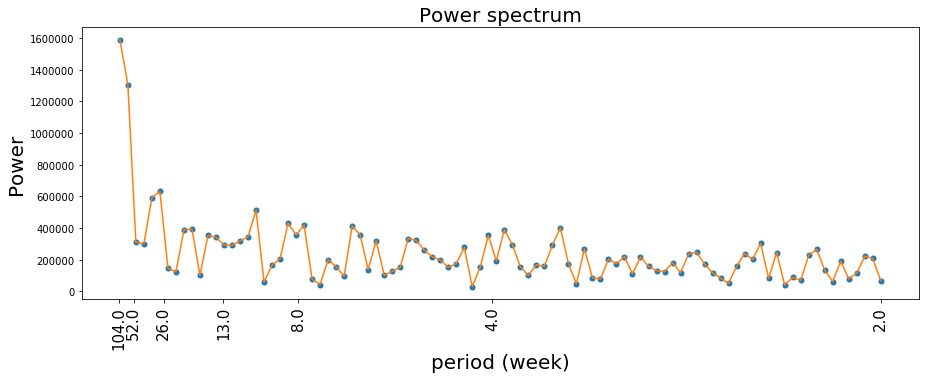

In [32]:
N=194
f = np.abs(np.fft.rfft(df3[9]))
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), 'o', ms=5)
ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-')

allperiods=[1./104,1./52,1./26,1./13,1./8,1./4,1./2]
ax.set_xticks(allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods],rotation=90, fontsize=15)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("Power spectrum", fontsize=20);

Figure 8. Power across periods for one random station, omitting the first the first two periods.
Note that there is a spike close to the 52 weeks, our point of interest.

In [33]:
#Let's see our five periods (in weeks) according to our frequency function for the sampling rate in our data.
1/np.fft.rfftfreq(N, 1.0)[0:5]

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


array([          inf,  194.        ,   97.        ,   64.66666667,   48.5       ])

The closest point to our period of interest (52 weeks) is point five (position 4 in python), with 48.5

In [34]:
# creating a list of points in position 5 (4 in python) for storing the data:
power_week=[]
for i in range (0,600)    :
    power_week.append((np.abs(np.fft.rfft(df3[i]))[4]))


In [35]:
# we take the list and sort it in descending order and take the first 4
top_4=sorted(power_week,reverse=True)[:4]

In [36]:
#this are the greatest powers for the stations
top_4

[2980160.6355953491, 2950388.929214194, 2931895.8769513387, 2402218.5809588572]

In [37]:
#we use the values to index the numpy with this top 4 stations
for i in range (0,4):
    print np.where(np.abs(np.fft.rfft(df3))[:,4]==top_4[i])

(array([0], dtype=int64),)
(array([194], dtype=int64),)
(array([150], dtype=int64),)
(array([327], dtype=int64),)


We get stations 0, 194, 150 and 357. 
I have no idea what's special about those. 
Also the array has 600 stations and MTA site mentions there are 472 stations, so not sure about what is in our array.
(source: http://web.mta.info/nyct/facts/ffsubway.htm).

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 

In [38]:
#importing necessary packages
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [39]:
#Professor Bianco kindly provided some sample code. 
#It's easier to copy paste it and create a new array with the same name as she used, lazy style. 
data=mtaRide

In [40]:
#flattening the cube for all stations and all types
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

In [41]:
#checking the new shape
tots.shape

(13800L, 194L)

In [42]:
print "Note that","23*600 =",23*600, "so that seems allright."

Note that 23*600 = 13800 so that seems allright.


In [43]:
#removing empty light curves
tots = tots[tots.std(1)>0]

C:\Users\usuario\Anaconda3\envs\Python2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [44]:
#checking new shape
tots.shape

(7660L, 194L)

In [45]:
#standardize the lightcurves before clustering, removing the variance by "row"
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

We can use the clustering, but we want to visualize it in 2-D, because our primate mind is simple and limited to interpret thing in more than two or three dimensions. So we do a PCA to reduce the information to two Principal components

In [46]:
#creating PCA object
pca = PCA(2)
valsproj=pca.fit(vals)

[ 63.39755526  23.65638023]


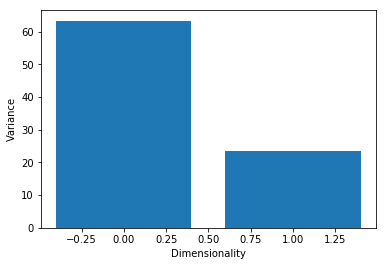

In [47]:
#making pca and graphing data
n=2
pca = PCA(n)
Xproj = pca.fit_transform(vals)
eigenvalues = pca.explained_variance_
print pca.explained_variance_
plt.bar(np.arange(n), eigenvalues);
plt.xlabel("Dimensionality")
plt.ylabel("Variance")
plt.show()

Figure 8. The variance explained by each of our two PCAs. Good enough

In [48]:
#Now we perform the clustering
n=10 # number of clusters

#train the model.
km=KMeans(random_state=324,n_clusters=n)
res=km.fit(Xproj)

In [49]:
#we check that the clustering in fact created the 10 clusters
unique(res.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

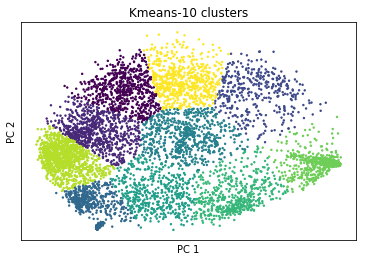

In [50]:
#we graph it in two dimsions
plt.scatter(Xproj[:, 0], Xproj[:, 1], s=2,c=res.labels_, cmap="viridis_r")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()

Figure 9. Ten clusters for our flattened data proyected in our two PCAs. 
My ability to interpret this is limited, but I can see there are 10 areas with different colors.
There is more variance that could be captured by the clustering, but we force it to use two PCA. 